> ## 데이터 청년 캠퍼스 13일차 과제
> ### <b>노재혁</b>

### 1. 타이타닉 생존여부 확인

- #### 로지스틱회귀모델을 이용해 타이타닉호 승선객의 생존여부 예측
- #### Age 결측치(NaN) 값은 다음과 같이 처리
    - 생존자(Survived = 1)는 생존자 나이의 평균으로 대체
    - 사망자(Survived = 0)는 사망자 나이의 평균으로 대체
- #### Embarked 결측치(NaN) 값은 가장 많은 값으로 대체

In [1]:
# 라이브러리 호출

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-pastel') # matplotlib style gallery 
sns.set(font_scale=2)
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline 

from sklearn import preprocessing
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

In [2]:
# threshold에 따른 분류 함수 정의
def PRED(y, threshold):
    Y = y.copy()
    Y[Y > threshold] = 1
    Y[Y <= threshold] = 0
    return(Y.astype(int))

In [3]:
# confusion matrix, accuracy, precision, recall
def eval_all(y_test, predict):
    confusion = confusion_matrix(y_test, predict)
    accuracy = accuracy_score(y_test, predict)
    precision = precision_score(y_test, predict)
    recall = recall_score(y_test, predict)
    print(f'confusion matrix\n{confusion}\n')
    print(f'[정확도:{accuracy:.4f}]\n[정밀도:{precision:.4f}]\n[재현율:{recall:.4f}]')

In [4]:
# 데이터 불러오기

df = pd.read_csv('data/train.csv')

In [5]:
# null 체크

for f in df.columns:
    null_val = df[f].isnull().sum()/df[f].shape[0]
    if null_val > 0:
        print(f'[feature : {f}]의 결측비율은 {100*null_val:.4f}% 입니다.')

[feature : Age]의 결측비율은 19.8653% 입니다.
[feature : Cabin]의 결측비율은 77.1044% 입니다.
[feature : Embarked]의 결측비율은 0.2245% 입니다.


In [6]:
# 생존자별 나이의 NaN값을 평균 나이로 대체
surv_mean_age = int(df.groupby(['Survived'])['Age'].mean()[0])
unsurv_mean_age = int(df.groupby(['Survived'])['Age'].mean()[1])
df.loc[df['Survived']==0, 'Age'] = df.loc[df['Survived']==0, 'Age'].fillna(surv_mean_age)
df.loc[df['Survived']==1, 'Age'] = df.loc[df['Survived']==1, 'Age'].fillna(unsurv_mean_age)

# Embarked 최빈값으로 대체
Embarked_freq = df['Embarked'].value_counts().index[0] # max값은 S:644이다.
df['Embarked'].fillna(Embarked_freq, inplace=True)

---------

### 2. 타이타닉 생존여부 확인
- #### 회귀계수 축소모형을 이용해 타이타닉호 승선객의 생존여부 예측

In [7]:
# 문자값을 이산형 숫자로 변환
features = ['Sex', 'Embarked']
for f in features:
    le = preprocessing.LabelEncoder()
    le = le.fit(df[f])
    df[f] = le.transform(df[f])

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,2
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,2


In [8]:
df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
df = sm.add_constant(df, has_constant='add')
feature_columns = list(df.columns.difference(['Survived']))
X = df[feature_columns]
y = df['Survived']
x_train, x_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.3,
                                                   random_state=121)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(623, 8) (268, 8) (623,) (268,)


> ### Logistic Regression

In [9]:
print('  <Logistic Regression>')
lr_clf = LogisticRegression()
lr_clf.fit(x_train, y_train)
lr_pred = lr_clf.predict(x_test)
eval_all(y_test, lr_pred)

fpr, tpr, thresholds = metrics.roc_curve(y_test, lr_pred)
auc = np.trapz(tpr,fpr)
print(f'\n AUC의 값: {auc}')

  <Logistic Regression>
confusion matrix
[[140  28]
 [ 29  71]]

[정확도:0.7873]
[정밀도:0.7172]
[재현율:0.7100]

 AUC의 값: 0.7716666666666667


> ### lasso

   <Lasso>
confusion matrix
[[142  26]
 [ 29  71]]

[정확도:0.7948]
[정밀도:0.7320]
[재현율:0.7100]

 AUC의 값: 0.8601785714285713

그래프는 아래와 같습니다.


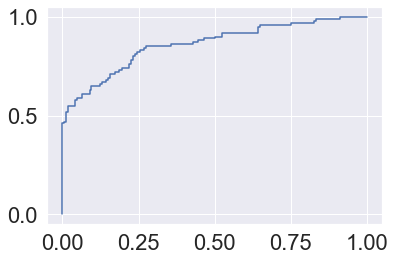

In [10]:
lasso = Lasso(alpha=0.01)
lasso.fit(x_train, y_train)

pred_y_lasso = lasso.predict(x_test)
pred_Y_lasso = PRED(pred_y_lasso, 0.5)

print('   <Lasso>')
eval_all(y_test, pred_Y_lasso)

fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_y_lasso)
auc = np.trapz(tpr,fpr)
print(f'\n AUC의 값: {auc}')

print('\n그래프는 아래와 같습니다.')
plt.plot(fpr, tpr)

> ### ridge

   <Ridge>
confusion matrix
[[142  26]
 [ 31  69]]

[정확도:0.7873]
[정밀도:0.7263]
[재현율:0.6900]

AUC의 값: 0.8616666666666667

그래프는 아래와 같습니다.


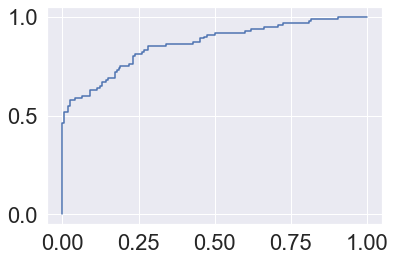

In [11]:
ridge = Ridge(alpha=0.01)
ridge.fit(x_train, y_train)

pred_y_ridge = ridge.predict(x_test)
pred_Y_ridge = PRED(pred_y_ridge, 0.5)

print('   <Ridge>')
eval_all(y_test, pred_Y_ridge)

fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_y_ridge)
auc = np.trapz(tpr,fpr)
print(f'\nAUC의 값: {auc}')
print('\n그래프는 아래와 같습니다.')
plt.plot(fpr, tpr)

> ### elasticNet

   <ElasticNet>
confusion matrix
[[142  26]
 [ 28  72]]

[정확도:0.7985]
[정밀도:0.7347]
[재현율:0.7200]

AUC의 값: 0.8610119047619048

그래프는 아래와 같습니다.


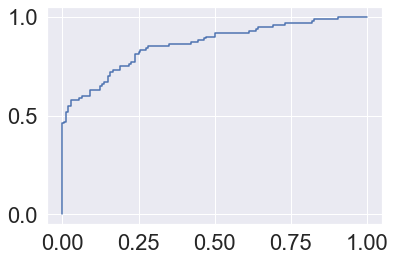

In [12]:
elastic = ElasticNet(alpha=0.01, l1_ratio=0.5)
elastic.fit(x_train, y_train)

pred_y_elastic = elastic.predict(x_test)
pred_Y_elastic = PRED(pred_y_elastic, 0.5)

print('   <ElasticNet>')
eval_all(y_test, pred_Y_elastic)

fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_y_elastic)
auc = np.trapz(tpr,fpr)
print(f'\nAUC의 값: {auc}')
print('\n그래프는 아래와 같습니다.')
plt.plot(fpr, tpr)